[tutorial](https://www.analyticsvidhya.com/blog/2018/04/introduction-to-graph-theory-network-analysis-python-codes/)

In [2]:
import networkx as nx

# Creating a Graph 
G = nx.Graph() # Right now G is empty

# Add a node
G.add_node(1) 
G.add_nodes_from([2,3]) # You can also add a list of nodes by passing a list argument

# Add edges 
G.add_edge(1,2)

e = (2,3)
G.add_edge(*e) # * unpacks the tuple
G.add_edges_from([(1,2), (1,3)]) # Just like nodes we can add edges from a list

* subgraph(G, nbunch)      - induced subgraph view of G on nodes in nbunch
* union(G1,G2)             - graph union
* disjoint_union(G1,G2)    - graph union assuming all nodes are different
* cartesian_product(G1,G2) - return Cartesian product graph
* compose(G1,G2)           - combine graphs identifying nodes common to both
* complement(G)            - graph complement
* create_empty_copy(G)     - return an empty copy of the same graph class
* convert_to_undirected(G) - return an undirected representation of G
* convert_to_directed(G)   - return a directed representation of G

## Accessing edges and nodes

Nodes and Edges can be accessed together using the G.nodes() and G.edges() methods. Individual nodes and edges can be accessed using the bracket/subscript notation.

In [3]:
G.nodes()

NodeView((1, 2, 3))

In [4]:
G.edges()

EdgeView([(1, 2), (1, 3), (2, 3)])

In [9]:
G[1] # same as G.adj[1]

AtlasView({2: {}, 3: {}})

In [6]:
G.adj[1]

AtlasView({2: {}, 3: {}})

In [11]:
G[1][2]

{}

In [13]:
G.edges[1,2]

{}

## Graph Visualization

Networkx provides basic functionality for visualizing graphs, but its main goal is to enable graph analysis rather than perform graph visualization. Graph visualization is hard and we will have to use specific tools dedicated for this task. Matplotlib offers some convenience functions. But GraphViz is probably the best tool for us as it offers a Python interface in the form of PyGraphViz (link to documentation below).

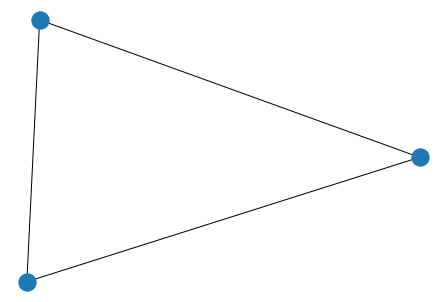

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
nx.draw(G)

In [21]:
#sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config
#!pip install pygraphviz
import pygraphviz as pgv
d={'1': {'2': None}, '2': {'1': None, '3': None}, '3': {'1': None}}
A = pgv.AGraph(data=d)
print(A) # This is the 'string' or simple representation of the Graph

strict graph "" {
	1 -- 2;
	2 -- 3;
	3 -- 1;
}



In [23]:
# Let us create another Graph where we can individually control the colour of each node
B = pgv.AGraph()

# Setting node attributes that are common for all nodes 
B.node_attr['style']='filled'
B.node_attr['shape']='circle'
B.node_attr['fixedsize']='true'
B.node_attr['fontcolor']='#FFFFFF'

# Creating and setting node attributes that vary for each node (using a for loop)
for i in range(16):
 B.add_edge(0,i)
 n=B.get_node(i)
 n.attr['fillcolor']="#%2x0000"%(i*16)
 n.attr['height']="%s"%(i/16.0+0.5)
 n.attr['width']="%s"%(i/16.0+0.5)
B.draw('star.png',prog="circo") # This creates a .png file in the local directory. Displayed below.


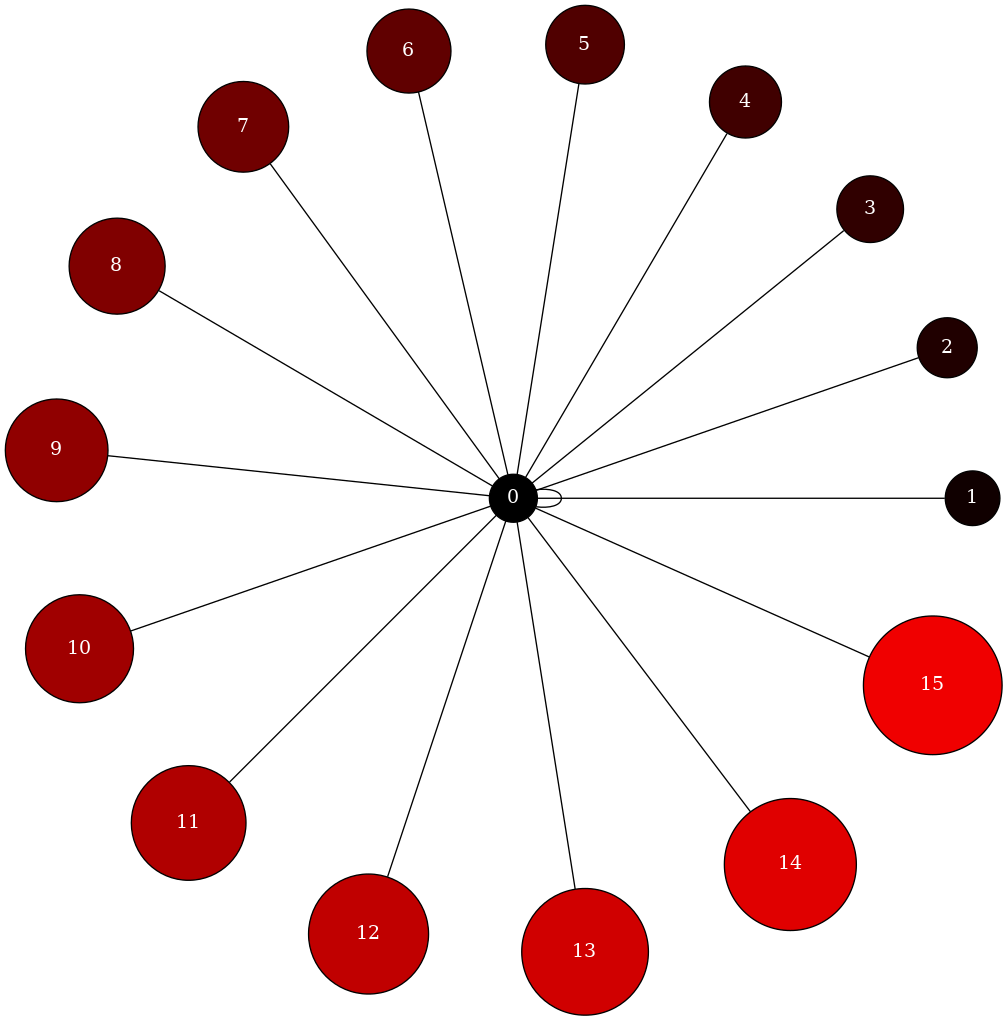

In [25]:
from IPython.display import Image
Image('/home/henri/Documents/Lighthouse-lab/lighthouse-data-notes/Week_9/w9-d3/star.png')

## Analysis on a Dataset

We will be looking to take a generic dataset (not one that is specifically intended to be used for Graphs) and do some manipulation (in pandas) so that it can be ingested into a Graph in the form of a edgelist. And edgelist is a list of tuples that contain the vertices defining every edge

The dataset we will be looking at comes from the Airlines Industry. It has some basic information on the Airline routes. There is a Source of a journey and a destination. There are also a few columns indicating arrival and departure times for each journey. As you can imagine this dataset lends itself beautifully to be analysed as a Graph. Imagine a few cities (nodes) connected by airline routes (edges). If you are an airline carrier, you can then proceed to ask a few questions like

   * What is the shortest way to get from A to B? In terms of distance and in terms of time
   * Is there a way to go from C to D?
   * Which airports have the heaviest traffic?
   * Which airport in “in between” most other airports? So that it can be converted into a local hub


In [27]:
import pandas as pd 
import numpy as np

data = pd.read_csv('/home/henri/Documents/Lighthouse-lab/lighthouse-data-notes/Week_9/w9-d3/airlines.csv')

In [28]:
data.shape

(100, 16)

In [34]:
data.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,std
0,2013,2,26,1807.0,1630,97.0,1956.0,1837,79.0,EV,4411,N13566,EWR,MEM,144.0,946,16:30:00
1,2013,8,17,1459.0,1445,14.0,1801.0,1747,14.0,B6,1171,N661JB,LGA,FLL,147.0,1076,14:45:00
2,2013,2,13,1812.0,1815,-3.0,2055.0,2125,-30.0,AS,7,N403AS,EWR,SEA,315.0,2402,18:15:00
3,2013,4,11,2122.0,2115,7.0,2339.0,2353,-14.0,B6,97,N656JB,JFK,DEN,221.0,1626,21:15:00
4,2013,8,5,1832.0,1835,-3.0,2145.0,2155,-10.0,AA,269,N3EYAA,JFK,SEA,358.0,2422,18:35:00


In [30]:
data.dtypes

year                int64
month               int64
day                 int64
dep_time          float64
sched_dep_time      int64
dep_delay         float64
arr_time          float64
sched_arr_time      int64
arr_delay         float64
carrier            object
flight              int64
tailnum            object
origin             object
dest               object
air_time          float64
distance            int64
dtype: object

   * We notice that origin and destination look like good choices for Nodes. Everything can then be imagined as either node or edge attributes. A single edge can be thought of as a journey. And such a journey will have various times, a flight number, an airplane tail number etc associated with it
   * We notice that the year, month, day and time information is spread over many columns. We want to create one datetime column containing all of this information. We also need to keep scheduled and actual time of arrival and departure separate. So we should finally have 4 datetime columns (Scheduled and actual times of arrival and departure)
   * Additionally, the time columns are not in a proper format. 4:30 pm is represented as 1630 instead of 16:30. There is no delimiter to split that column. One approach is to use pandas string methods and regular expressions
   * We should also note that sched_dep_time and sched_arr_time are int64 dtype and dep_time and arr_time are float64 dtype
   * An additional complication is NaN values


In [32]:
# converting sched_dep_time to 'std' - Scheduled time of departure
data['std'] = data.sched_dep_time.astype(str).str.replace('(\d{2}$)', '') + ':' + data.sched_dep_time.astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

In [35]:
# converting sched_arr_time to 'sta' - Scheduled time of arrival
data['sta'] = data.sched_arr_time.astype(str).str.replace('(\d{2}$)', '') + ':' + data.sched_arr_time.astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

# converting dep_time to 'atd' - Actual time of departure
data['atd'] = data.dep_time.fillna(0).astype(np.int64).astype(str).str.replace('(\d{2}$)', '') + ':' + data.dep_time.fillna(0).astype(np.int64).astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

In [38]:
# converting arr_time to 'ata' - Actual time of arrival
data['ata'] = data.arr_time.fillna(0).astype(np.int64).astype(str).str.replace('(\d{2}$)', '') + ':' + data.arr_time.fillna(0).astype(np.int64).astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

In [39]:
data.head()


,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,std,sta,atd,ata
0,2013,2,26,1807.0,1630,97.0,1956.0,1837,79.0,EV,4411,N13566,EWR,MEM,144.0,946,16:30:00,18:37:00,18:07:00,19:56:00
1,2013,8,17,1459.0,1445,14.0,1801.0,1747,14.0,B6,1171,N661JB,LGA,FLL,147.0,1076,14:45:00,17:47:00,14:59:00,18:01:00
2,2013,2,13,1812.0,1815,-3.0,2055.0,2125,-30.0,AS,7,N403AS,EWR,SEA,315.0,2402,18:15:00,21:25:00,18:12:00,20:55:00
3,2013,4,11,2122.0,2115,7.0,2339.0,2353,-14.0,B6,97,N656JB,JFK,DEN,221.0,1626,21:15:00,23:53:00,21:22:00,23:39:00
4,2013,8,5,1832.0,1835,-3.0,2145.0,2155,-10.0,AA,269,N3EYAA,JFK,SEA,358.0,2422,18:35:00,21:55:00,18:32:00,21:45:00


In [41]:
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

In [42]:
# finally we drop the columns we don't need
data = data.drop(columns = ['year', 'month', 'day'])

In [43]:
data.head()

,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,std,sta,atd,ata,date
0,1807.0,1630,97.0,1956.0,1837,79.0,EV,4411,N13566,EWR,MEM,144.0,946,16:30:00,18:37:00,18:07:00,19:56:00,2013-02-26
1,1459.0,1445,14.0,1801.0,1747,14.0,B6,1171,N661JB,LGA,FLL,147.0,1076,14:45:00,17:47:00,14:59:00,18:01:00,2013-08-17
2,1812.0,1815,-3.0,2055.0,2125,-30.0,AS,7,N403AS,EWR,SEA,315.0,2402,18:15:00,21:25:00,18:12:00,20:55:00,2013-02-13
3,2122.0,2115,7.0,2339.0,2353,-14.0,B6,97,N656JB,JFK,DEN,221.0,1626,21:15:00,23:53:00,21:22:00,23:39:00,2013-04-11
4,1832.0,1835,-3.0,2145.0,2155,-10.0,AA,269,N3EYAA,JFK,SEA,358.0,2422,18:35:00,21:55:00,18:32:00,21:45:00,2013-08-05


In [44]:
import networkx as nx
FG = nx.from_pandas_edgelist(data, source='origin', target='dest', edge_attr=True,)

In [46]:
FG.nodes()

NodeView(('EWR', 'MEM', 'LGA', 'FLL', 'SEA', 'JFK', 'DEN', 'ORD', 'MIA', 'PBI', 'MCO', 'CMH', 'MSP', 'IAD', 'CLT', 'TPA', 'DCA', 'SJU', 'ATL', 'BHM', 'SRQ', 'MSY', 'DTW', 'LAX', 'JAX', 'RDU', 'MDW', 'DFW', 'IAH', 'SFO', 'STL', 'CVG', 'IND', 'RSW', 'BOS', 'CLE'))

In [47]:
FG.edges()

EdgeView([('EWR', 'MEM'), ('EWR', 'SEA'), ('EWR', 'MIA'), ('EWR', 'ORD'), ('EWR', 'MSP'), ('EWR', 'TPA'), ('EWR', 'MSY'), ('EWR', 'DFW'), ('EWR', 'IAH'), ('EWR', 'SFO'), ('EWR', 'CVG'), ('EWR', 'IND'), ('EWR', 'RDU'), ('EWR', 'IAD'), ('EWR', 'RSW'), ('EWR', 'BOS'), ('EWR', 'PBI'), ('EWR', 'LAX'), ('EWR', 'MCO'), ('EWR', 'SJU'), ('LGA', 'FLL'), ('LGA', 'ORD'), ('LGA', 'PBI'), ('LGA', 'CMH'), ('LGA', 'IAD'), ('LGA', 'CLT'), ('LGA', 'MIA'), ('LGA', 'DCA'), ('LGA', 'BHM'), ('LGA', 'RDU'), ('LGA', 'ATL'), ('LGA', 'TPA'), ('LGA', 'MDW'), ('LGA', 'DEN'), ('LGA', 'MSP'), ('LGA', 'DTW'), ('LGA', 'STL'), ('LGA', 'MCO'), ('LGA', 'CVG'), ('LGA', 'IAH'), ('FLL', 'JFK'), ('SEA', 'JFK'), ('JFK', 'DEN'), ('JFK', 'MCO'), ('JFK', 'TPA'), ('JFK', 'SJU'), ('JFK', 'ATL'), ('JFK', 'SRQ'), ('JFK', 'DCA'), ('JFK', 'DTW'), ('JFK', 'LAX'), ('JFK', 'JAX'), ('JFK', 'CLT'), ('JFK', 'PBI'), ('JFK', 'CLE'), ('JFK', 'IAD'), ('JFK', 'BOS')])

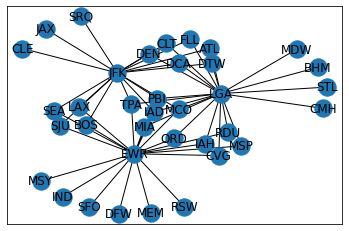

In [48]:
nx.draw_networkx(FG, with_labels=True) # Quick view of the Graph. As expected we see 3 very busy airports

In [49]:
nx.algorithms.degree_centrality(FG) # Notice the 3 airports from which all of our 100 rows of data originates
nx.density(FG) # Average edge density of the Graphs

0.09047619047619047

In [51]:
nx.average_shortest_path_length(FG) # Average shortest path length for ALL paths in the Graph

2.36984126984127

In [52]:
nx.average_degree_connectivity(FG) # For a node of degree k - What is the average of its neighbours' degree?

{20: 1.95, 1: 19.307692307692307, 2: 19.0625, 17: 2.0588235294117645, 3: 19.0}

In [53]:
# Let us find all the paths available
for path in nx.all_simple_paths(FG, source='JAX', target='DFW'):
 print(path)

['JAX', 'JFK', 'DEN', 'LGA', 'ORD', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'PBI', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'IAD', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'MIA', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'RDU', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'TPA', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'MSP', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'MCO', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'CVG', 'EWR', 'DFW']
['JAX', 'JFK', 'DEN', 'LGA', 'IAH', 'EWR', 'DFW']
['JAX', 'JFK', 'SEA', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'ORD', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'PBI', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'IAD', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'MIA', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'RDU', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'TPA', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'MSP', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'CVG', 'EWR', 'DFW']
['JAX', 'JFK', 'MCO', 'LGA', 'IAH', 'EWR', 'DFW']
['JAX', 'JFK',

In [54]:
# Let us find the dijkstra path from JAX to DFW.
# You can read more in-depth on how dijkstra works from this resource - https://courses.csail.mit.edu/6.006/fall11/lectures/lecture16.pdf
dijpath = nx.dijkstra_path(FG, source='JAX', target='DFW')
dijpath

['JAX', 'JFK', 'SEA', 'EWR', 'DFW']

In [55]:
# Let us try to find the dijkstra path weighted by airtime (approximate case)
shortpath = nx.dijkstra_path(FG, source='JAX', target='DFW', weight='air_time')
shortpath

['JAX', 'JFK', 'BOS', 'EWR', 'DFW']